# Imports

In [1]:
%matplotlib inline
import numpy as np
import math
import torch
import time
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

## Goal of Optimization

We model f(x) as the risk function and g(x) as the empirical risk function

In [2]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

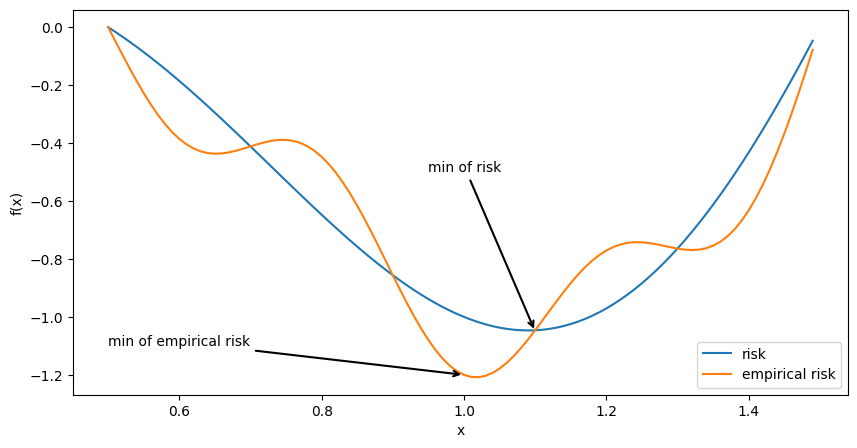

In [3]:
def annotate(text, xy, xytext):
    plt.gca().annotate(text, xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='->', lw=1.5))

x = torch.arange(0.5, 1.5, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, f(x), label='risk')
plt.plot(x, g(x), label='empirical risk')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('min of empirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

# Optimization Challenges

## Local Minima

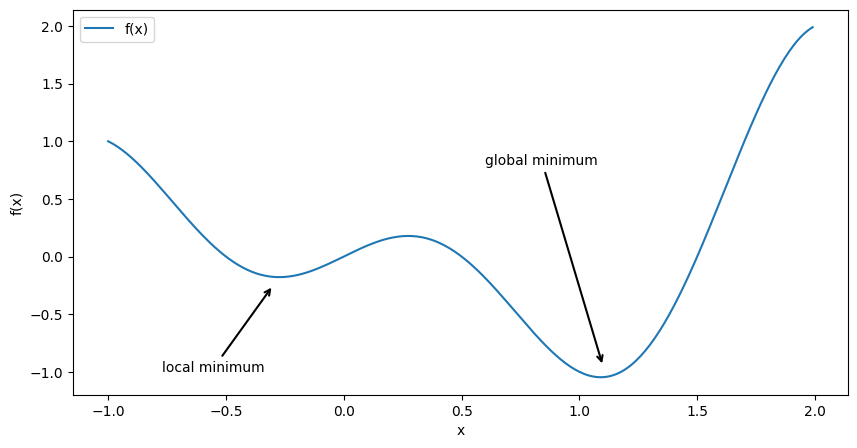

In [4]:
x = torch.arange(-1.0, 2.0, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, f(x), label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

## Saddle Points

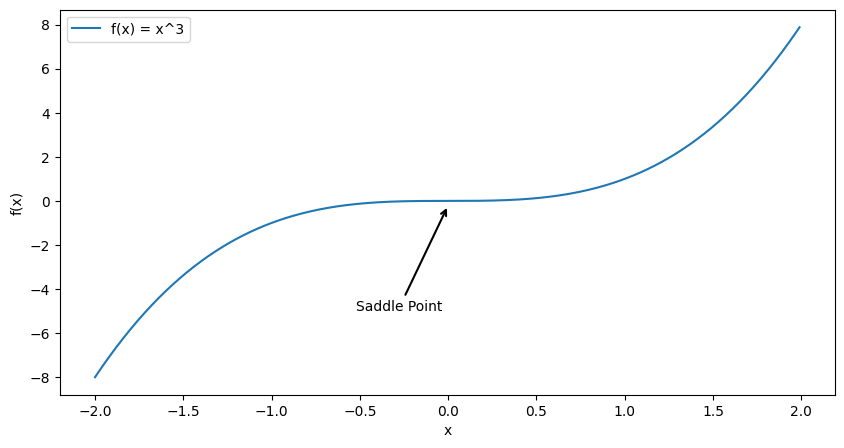

In [5]:
x = torch.arange(-2.0, 2.0, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, x**3, label='f(x) = x^3')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('Saddle Point', (0, -0.2), (-0.52, -5.0))

Saddle points in higher dimensions

c:\Users\Ishaan\Desktop\Personal Projects\Deep-Learning\.venv\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.5, 'y')

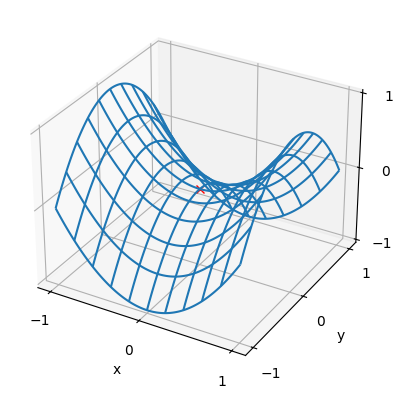

In [6]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y')

To differentiate between local minima, local maxima and saddle points in high dimensional data, we look at the hessian matrix at the zero-gradient position

## Vanishing Gradients

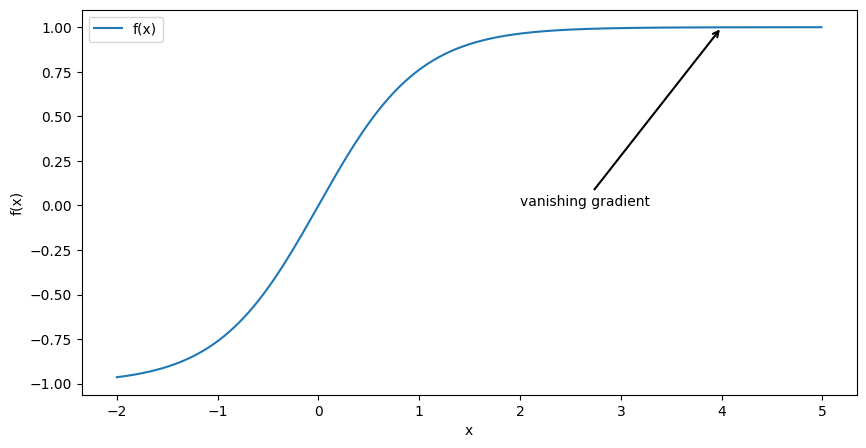

In [7]:
x = torch.arange(-2.0, 5.0, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, torch.tanh(x), label = 'f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('vanishing gradient', (4, 1), (2, 0.0))

# Convexity

## Convex Functions

In [8]:
f = lambda x: 0.5 * x**2 # Convex
g = lambda x: torch.cos(np.pi * x) # Non-convex
h = lambda x: torch.exp(0.5 * x) # Convex

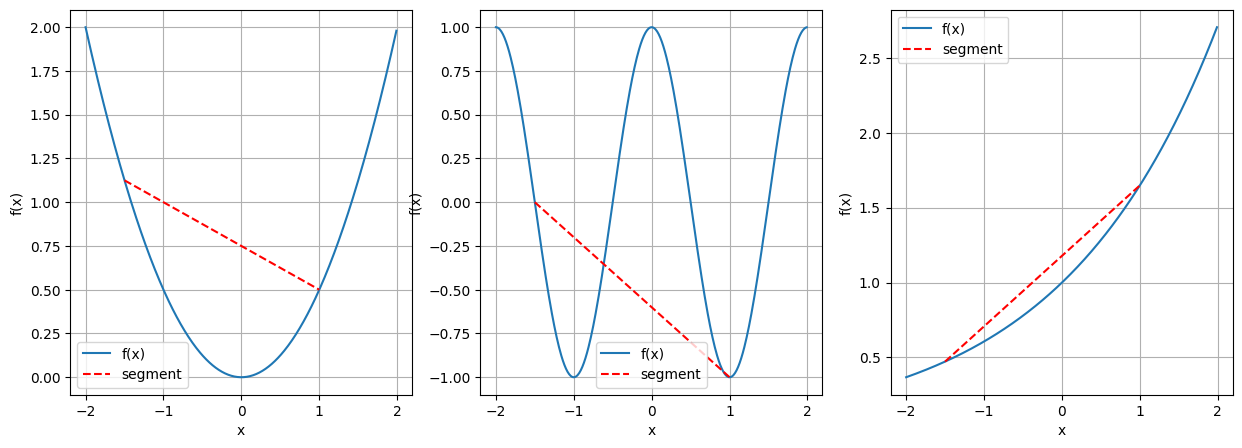

In [9]:
x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
_, ax = plt.subplots(1, 3, figsize=(15, 5))
for ax, func in zip(ax, [f, g, h]):
    ax.plot(x, func(x), label='f(x)')
    ax.plot(segment, func(segment), 'r--', label='segment')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
    ax.grid(True)

# Properties of Convex Functions

## Local Minima are Global Minima

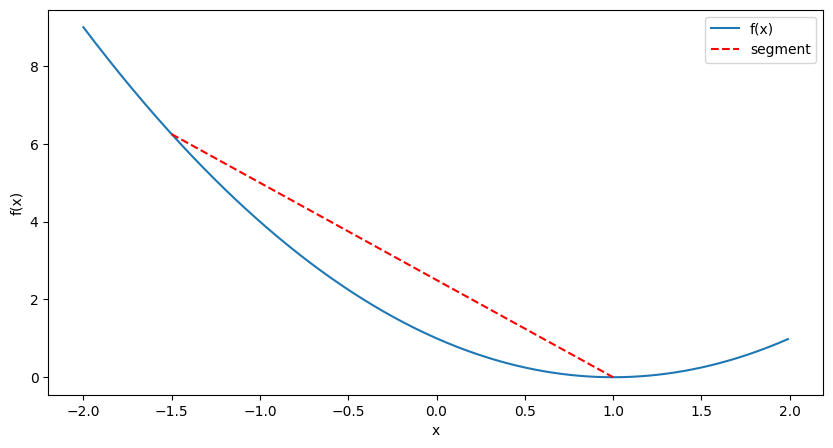

In [10]:
f = lambda x: (x - 1) ** 2
plt.figure(figsize=(10, 5))
plt.plot(x, f(x), label='f(x)')
plt.plot(segment, f(segment), 'r--', label='segment')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

This property ensures that we do not get stuck when one or more minima exists. There are cases where there is no minima over a certain range

# Gradient Descent

In [11]:
def f(x):
    return x ** 2

def f_grad(x):
    return 2 * x

In [12]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x = {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x = 0.060466


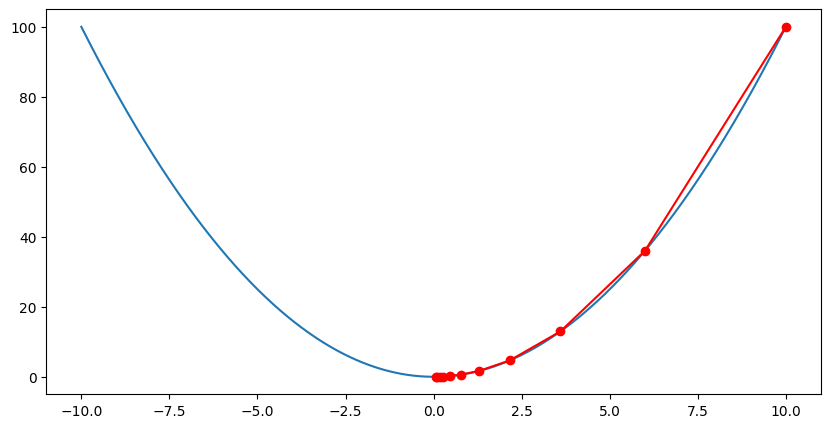

In [13]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    plt.figure(figsize=(10, 5))
    plt.plot(f_line, f(f_line), label='f(x)')
    plt.plot(results, f(torch.tensor(results)), 'ro-', label='trace')
    plt.show()

show_trace(results, f)

## Learning Rate

epoch 10, x = 3.486784


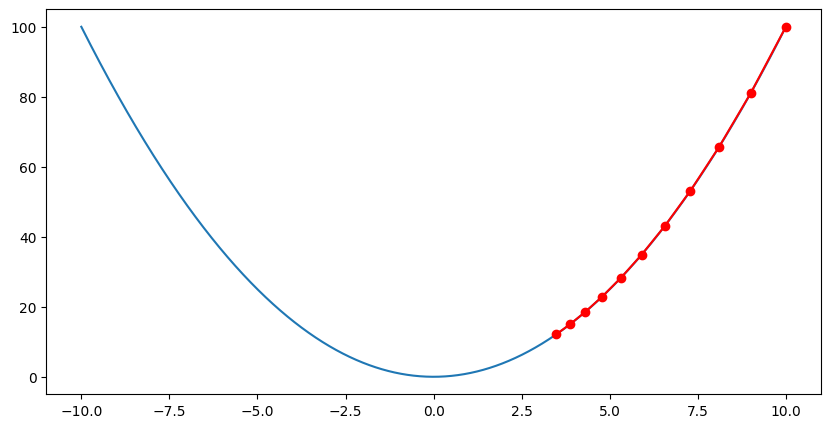

In [14]:
show_trace(gd(0.05, f_grad), f)

The above example shows an instance where the learning rate is too slow and thus does not reach the minima

epoch 10, x = 61.917364


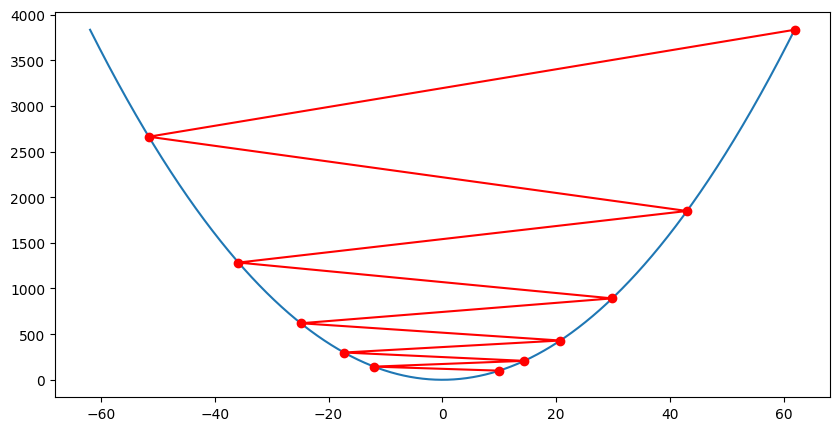

In [15]:
show_trace(gd(1.1, f_grad), f)

The above example shows an isntance where the learning rate is too fast and may or may not reach the minima

## Local Minima

epoch 10, x = -1.528166


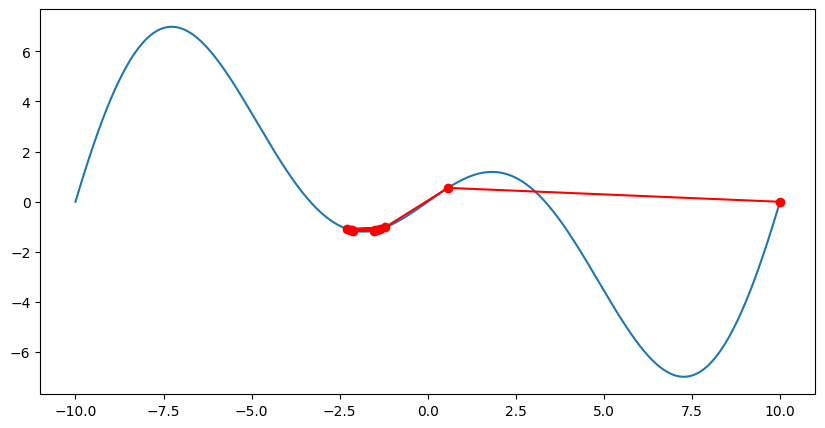

In [16]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

Above is an example of a nonconvex function which has many local minima. The choice of learning rate and how well conditioned the problem is, we may end up with many solutions. A high learning rate can lead to a poor local minimum

# Multivariate Gradient Descent

In [17]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):  #@save
    """Show the trace of 2D variables during optimization."""
    plt.figure(figsize=(10, 5))
    plt.title('2D Optimization Trace')
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1), indexing='ij')
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


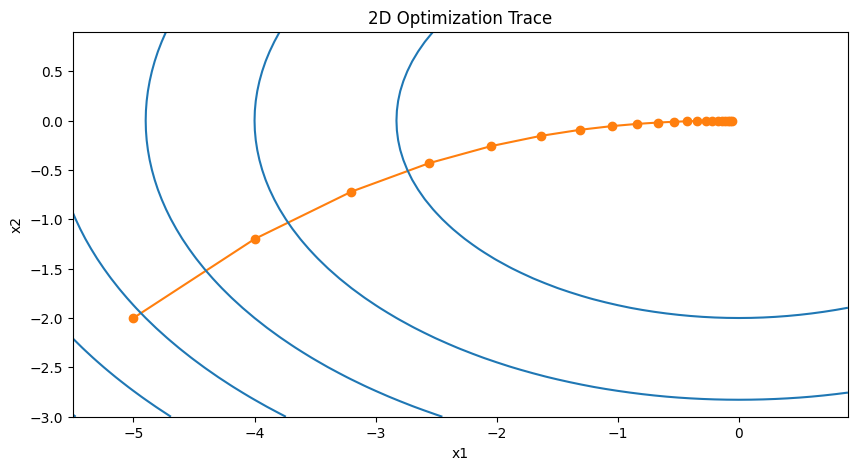

In [18]:
def f_2d(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

# Adaptive Methods

## Newton's Method

Newton's method on a convex function

epoch 10, x: tensor(0.)


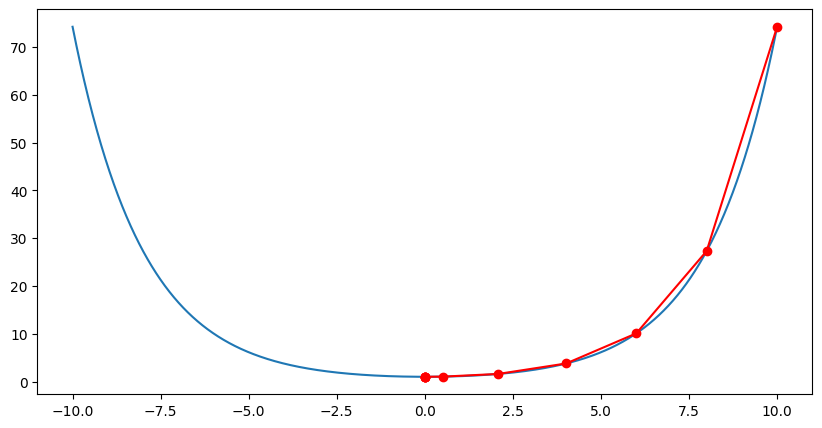

In [19]:
c = torch.tensor(0.5)

def f(x):  # Objective function
    return torch.cosh(c * x)

def f_grad(x):  # Gradient of the objective function
    return c * torch.sinh(c * x)

def f_hess(x):  # Hessian of the objective function
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

Newton's method on a nonconvex function

epoch 10, x: tensor(26.8341)


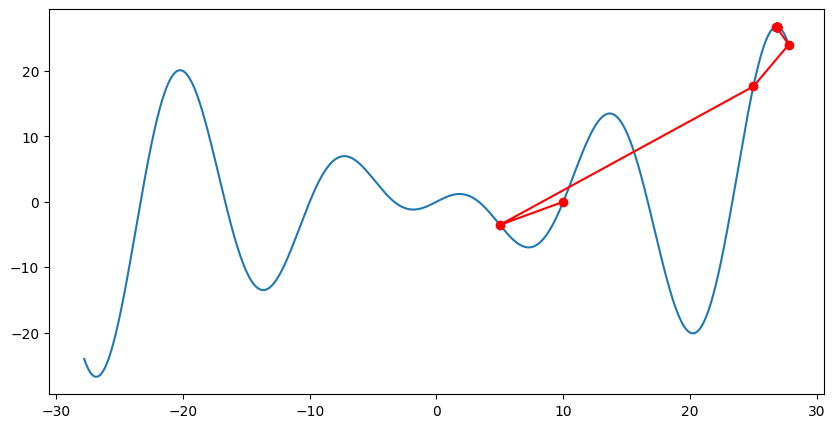

In [20]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # Hessian of the objective function
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

epoch 10, x: tensor(7.2699)


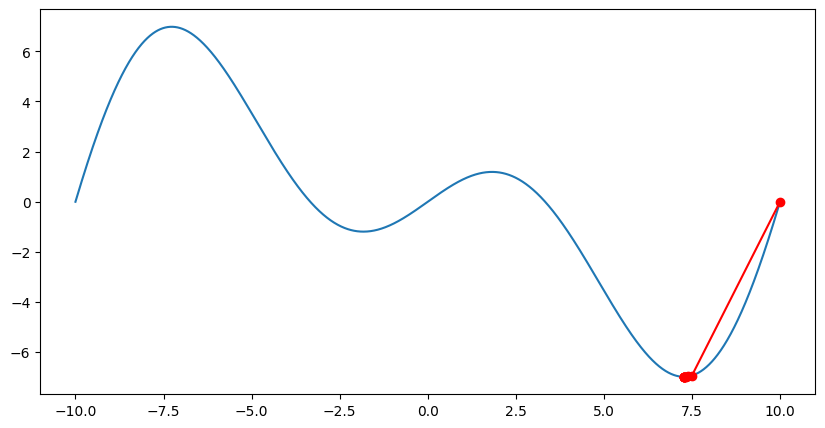

In [21]:
show_trace(newton(0.5), f)

# Stochastic Gradient Descent

Instead of incurring a cost of O(n) to calculate the gradient of the objective function, we can use the stochastic gradient as a good estimate of the gradient and bring down the computational cost to O(1) i.e. a significant improvement

epoch 50, x1: -0.127161, x2: 0.060474


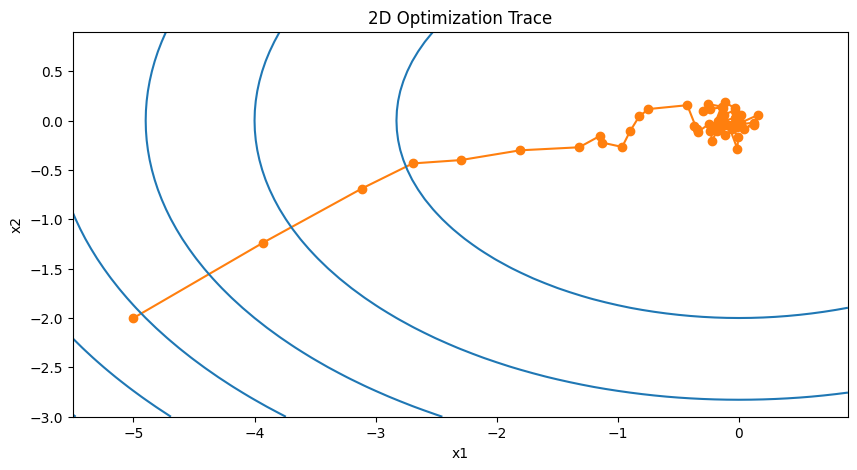

In [22]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
show_trace_2d(f, train_2d(sgd, steps=50, f_grad=f_grad))

The trajectory of the variables in SGD is much more noisy than the ones we observed in Gradient Descent

## Dynamic Learning Rate

epoch 1000, x1: -0.837227, x2: -0.018601


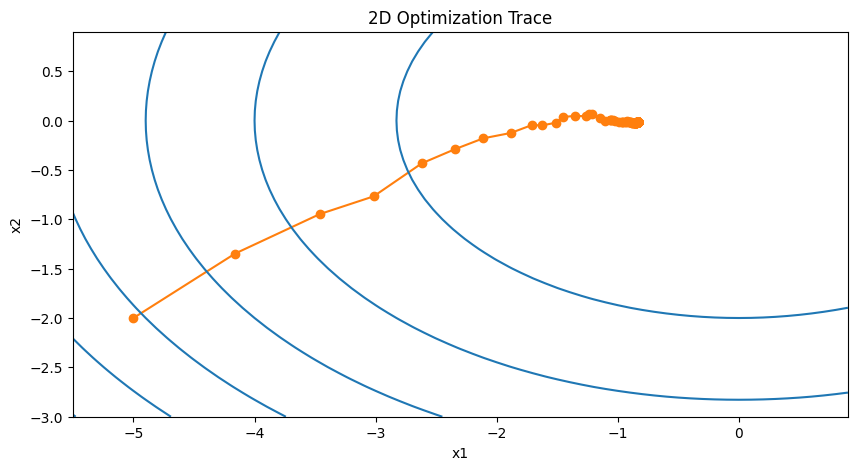

In [23]:
def exponential_lr():
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
show_trace_2d(f, train_2d(sgd, steps=1000, f_grad=f_grad))

# Minibatch Stochastic Gradient Descent

In [24]:
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)


In [25]:
class Timer:
    """Recording multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [26]:
timer = Timer()
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.2350022792816162

In [27]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.012000560760498047

In [28]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

gigaflops = [0.03 / i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.024, column 2.500, full 5.000


Here we can view the difference between computing the dot product of two matrics element-wise (slowest), one column at a time and at one go (fastest)

## Minibatches

Using minibatches makes us more computationally efficient with an added benefit of reducing variance due to the reduction of standard deviation by a factor of $b^{-1/2}$

In [29]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {0.03 / timer.times[3]:.3f}')

performance in Gigaflops: block 29.995


## Reading the dataset

In [30]:

def linreg(X, w, b):
    """Linear regression model."""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """Squared loss function."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = 0.0
    num_batches = 0
    with torch.no_grad():
        for X, y in data_iter:
            l = loss(net(X), y)
            metric += l.sum()
            num_batches += y.numel()
    return metric / num_batches

class Animator:
    """Simple animator that stores data and shows final plot."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(10, 6)):
        self.xlabel = xlabel or 'x'
        self.ylabel = ylabel or 'y' 
        self.xlim = xlim
        self.ylim = ylim
        self.xscale = xscale
        self.yscale = yscale
        self.fmts = fmts
        self.figsize = figsize
        self.X, self.Y = [], []
        self.legend = legend or []

    def add(self, x, y):
        """Add data points to the plot."""
        # Handle 0-d tensors by converting to float first
        if hasattr(y, 'item') and hasattr(y, 'dim') and y.dim() == 0:
            y = float(y.item())
        if hasattr(x, 'item') and hasattr(x, 'dim') and x.dim() == 0:
            x = float(x.item())
        
        # Convert to list if not already
        if not hasattr(y, "__len__"):
            y = [y]
        if not hasattr(x, "__len__"):
            x = [x] * len(y)
        
        # Initialize data structure if needed
        if not self.X:
            self.X = [[] for _ in range(len(y))]
        if not self.Y:
            self.Y = [[] for _ in range(len(y))]
            
        # Add new data points
        for i, (x_val, y_val) in enumerate(zip(x, y)):
            if x_val is not None and y_val is not None:
                self.X[i].append(float(x_val))
                self.Y[i].append(float(y_val))
        
        # Print progress every few points
        if len(self.X[0]) % 5 == 0:
            print(f"  Step {len(self.X[0])}: Loss = {float(y[0]):.4f}")
    
    def show(self):
        """Display the final plot."""
        plt.figure(figsize=self.figsize)
        
        for i, (x_data, y_data) in enumerate(zip(self.X, self.Y)):
            if len(x_data) > 0:
                fmt = self.fmts[i % len(self.fmts)]
                label = self.legend[i] if i < len(self.legend) else f'Series {i}'
                plt.plot(x_data, y_data, fmt, label=label, linewidth=2)
        
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        if self.xlim:
            plt.xlim(self.xlim)
        if self.ylim:
            plt.ylim(self.ylim)
        plt.xscale(self.xscale)
        plt.yscale(self.yscale)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.title(f'{self.ylabel} vs {self.xlabel}')
        plt.tight_layout()
        plt.show()


In [31]:
airfoil_path = 'airfoil+self+noise/airfoil_self_noise.dat'
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(airfoil_path, dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    features, labels = data[:n, :-1], data[:n, -1]
    dataset = torch.utils.data.TensorDataset(features, labels)
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    return data_iter, data.shape[1]-1

## Implementation from scratch

In [32]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [33]:
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    
    # Train
    animator = Animator(xlabel='Epoch', ylabel='Loss', legend=['Training Loss'])
    n, timer = 0, Timer()
    timer.start()
    
    print(f"Training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                current_loss = evaluate_loss(net, data_iter, loss)
                #animator.add(n/X.shape[0]/len(data_iter), current_loss)
                animator.add(float(n/X.shape[0]/len(data_iter)), current_loss)
                timer.start()
    
    timer.stop()
    final_loss = animator.Y[0][-1] if animator.Y[0] else 0
    print(f'Final loss: {final_loss:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    
    # Show the training plot
    animator.show()
    
    return timer.cumsum(), animator.Y[0]

Training for 10 epochs...
  Step 5: Loss = 0.2472
Final loss: 0.247, 0.028 sec/epoch


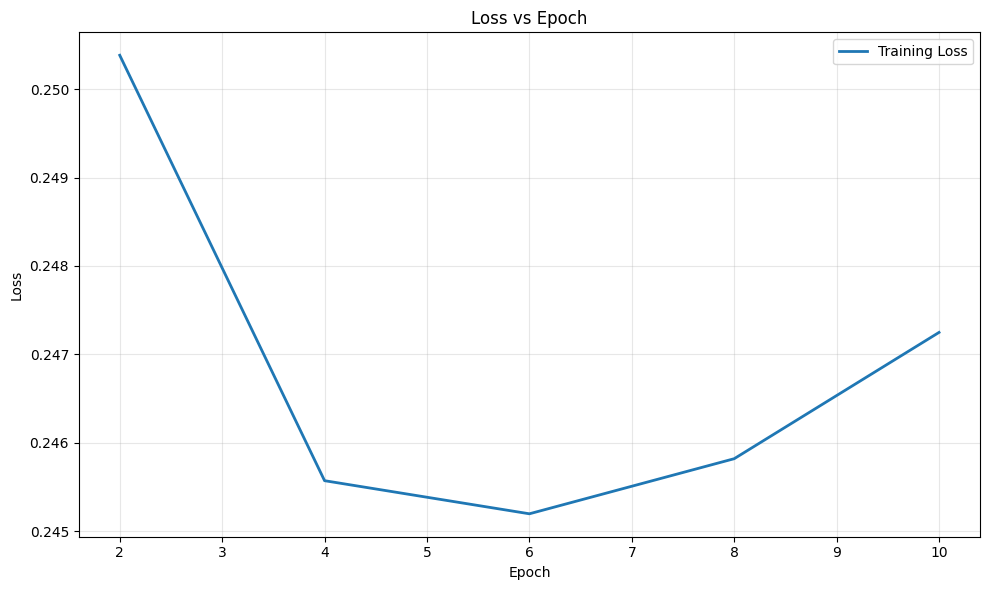

In [34]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

1. GRADIENT DESCENT (Full Batch)
Training for 10 epochs...
  Step 5: Loss = 0.2484
Final loss: 0.248, 0.011 sec/epoch


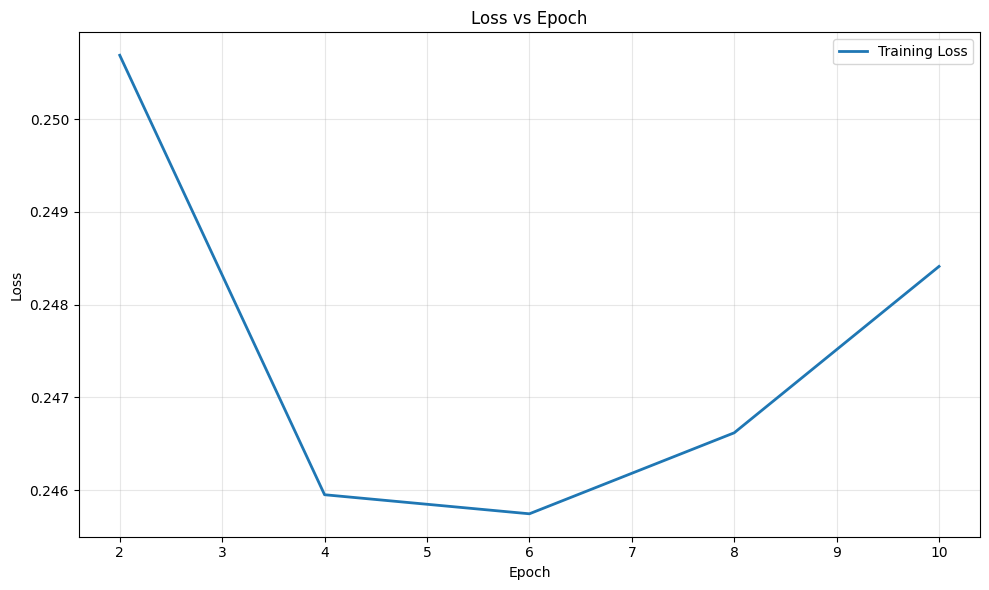

In [35]:
# Clear any existing plots
plt.close('all')

# 1. Gradient Descent (batch_size = full dataset = 1500)
print("="*50)
print("1. GRADIENT DESCENT (Full Batch)")
print("="*50)
gd_res = train_sgd(1, 1500, 10)  # lr=1, batch_size=1500 (full dataset)

2. STOCHASTIC GRADIENT DESCENT (SGD)
Training for 10 epochs...
  Step 5: Loss = 0.2470
  Step 10: Loss = 0.2517
  Step 15: Loss = 0.2431
  Step 20: Loss = 0.2431
  Step 25: Loss = 0.2428
  Step 30: Loss = 0.2467
  Step 35: Loss = 0.2450
  Step 40: Loss = 0.2448
  Step 45: Loss = 0.2435
  Step 50: Loss = 0.2478
  Step 55: Loss = 0.2447
  Step 60: Loss = 0.2450
  Step 65: Loss = 0.2454
  Step 70: Loss = 0.2434
  Step 75: Loss = 0.2470
Final loss: 0.247, 0.489 sec/epoch


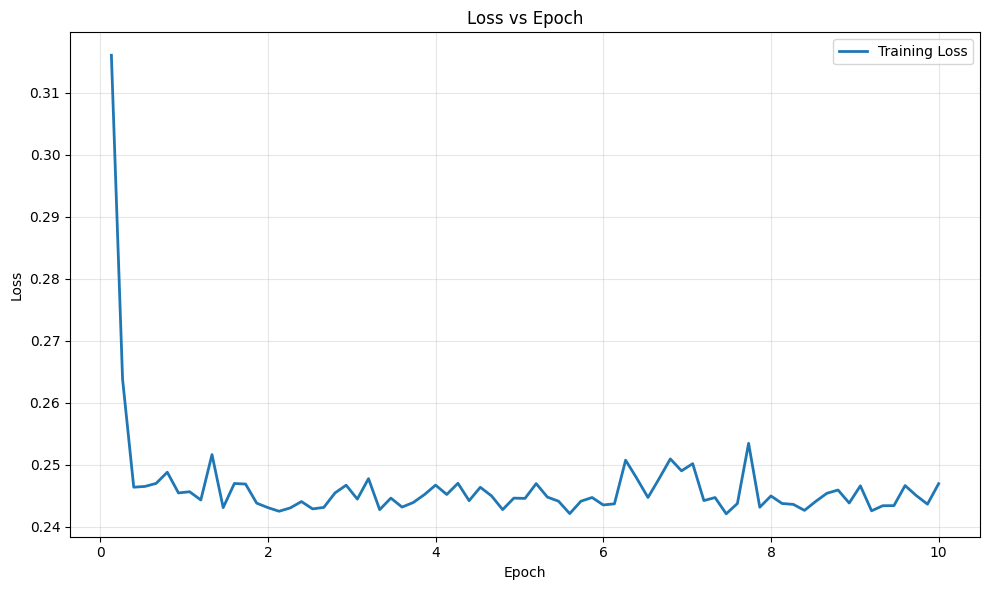

In [36]:
# 2. Stochastic Gradient Descent (batch_size = 1)
print("="*50)
print("2. STOCHASTIC GRADIENT DESCENT (SGD)")
print("="*50)
sgd_res = train_sgd(0.005, 1, 10)  # lr=0.005, batch_size=1


3. MINIBATCH SGD (batch_size=10)
Training for 10 epochs...
  Step 5: Loss = 0.2501
  Step 10: Loss = 0.2430
  Step 15: Loss = 0.2420
  Step 20: Loss = 0.2448
  Step 25: Loss = 0.2486
  Step 30: Loss = 0.2434
  Step 35: Loss = 0.2436
  Step 40: Loss = 0.2490
  Step 45: Loss = 0.2436
  Step 50: Loss = 0.2518
  Step 55: Loss = 0.2434
  Step 60: Loss = 0.2463
  Step 65: Loss = 0.2455
  Step 70: Loss = 0.2442
  Step 75: Loss = 0.2439
Final loss: 0.244, 0.066 sec/epoch


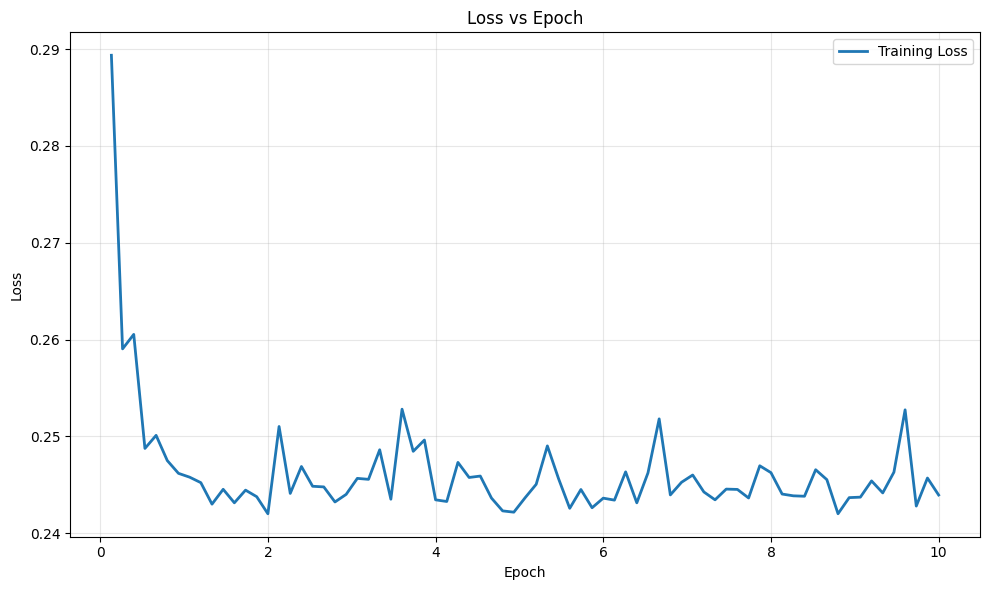

In [37]:
# 3. Minibatch SGD with batch_size = 10
print("="*50)
print("3. MINIBATCH SGD (batch_size=10)")
print("="*50)
minibatch_10_res = train_sgd(0.05, 10, 10)  # lr=0.05, batch_size=10


4. MINIBATCH SGD (batch_size=100)
Training for 10 epochs...
  Step 5: Loss = 0.3112
  Step 10: Loss = 0.2630
  Step 15: Loss = 0.2495
  Step 20: Loss = 0.2448
  Step 25: Loss = 0.2441
  Step 30: Loss = 0.2430
  Step 35: Loss = 0.2429
  Step 40: Loss = 0.2425
  Step 45: Loss = 0.2423
  Step 50: Loss = 0.2427
  Step 55: Loss = 0.2428
  Step 60: Loss = 0.2421
  Step 65: Loss = 0.2426
  Step 70: Loss = 0.2423
  Step 75: Loss = 0.2420
Final loss: 0.242, 0.016 sec/epoch


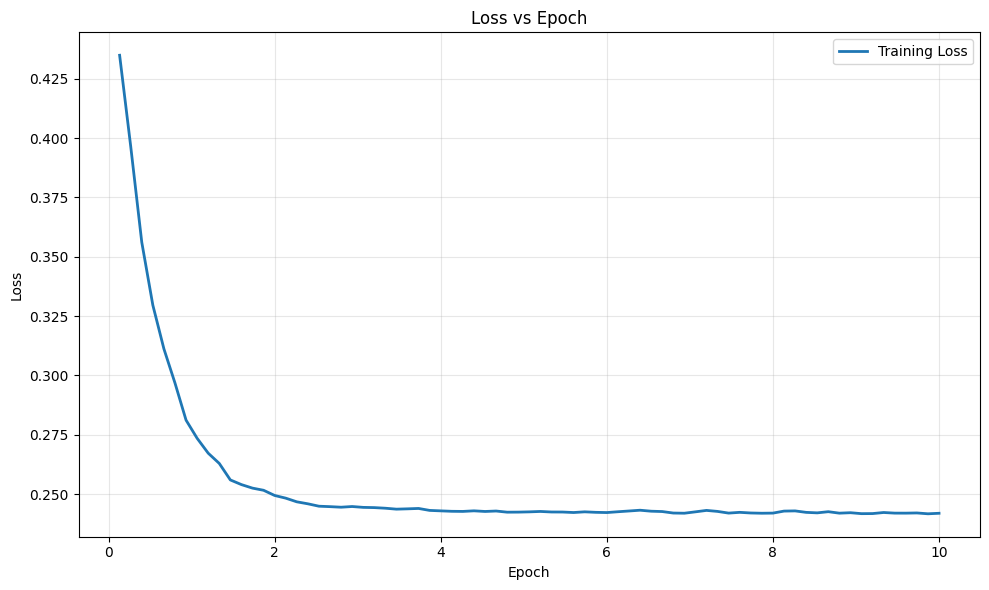

In [38]:
# 4. Minibatch SGD with batch_size = 100
print("="*50)
print("4. MINIBATCH SGD (batch_size=100)")
print("="*50)
minibatch_100_res = train_sgd(0.1, 100, 10)  # lr=0.1, batch_size=100


COMPARISON OF ALL OPTIMIZATION METHODS


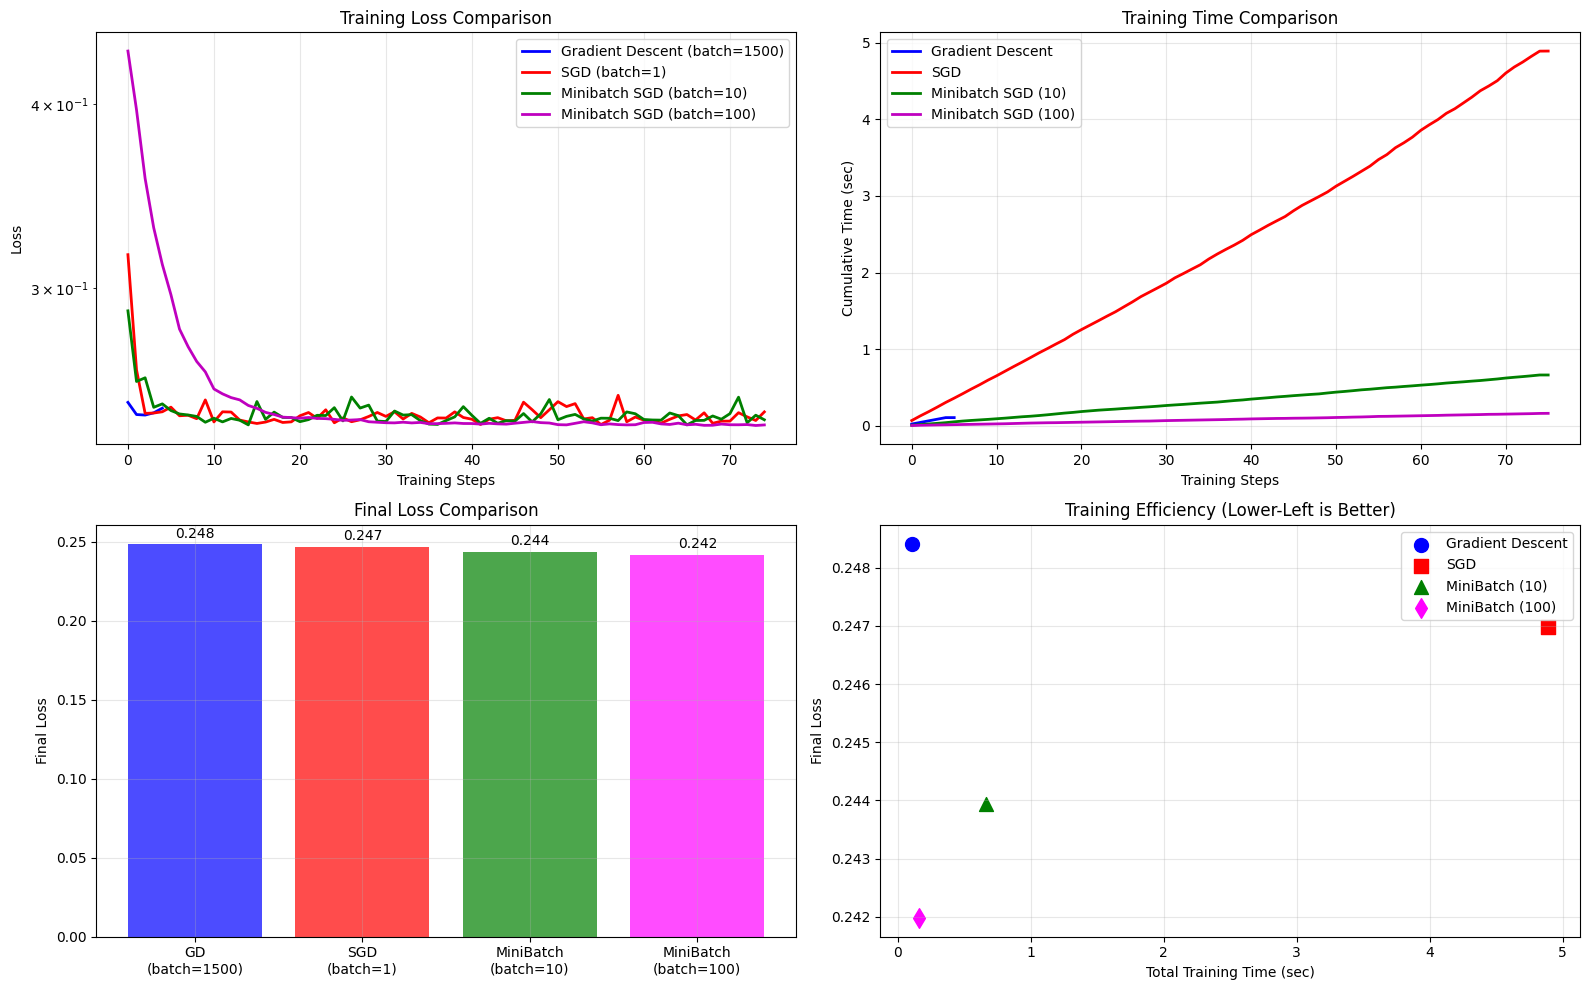


SUMMARY STATISTICS:
----------------------------------------
Gradient Descent:      Final Loss = 0.2484, Time = 0.107s
SGD (batch=1):         Final Loss = 0.2470, Time = 4.892s
MiniBatch SGD (b=10):  Final Loss = 0.2439, Time = 0.663s
MiniBatch SGD (b=100): Final Loss = 0.2420, Time = 0.163s


In [39]:
# Comprehensive comparison of all optimization methods
print("="*60)
print("COMPARISON OF ALL OPTIMIZATION METHODS")
print("="*60)

plt.figure(figsize=(16, 10))

# Plot 1: Loss Comparison
plt.subplot(2, 2, 1)
if len(gd_res[1]) > 0:
    plt.plot(gd_res[1], 'b-', label='Gradient Descent (batch=1500)', linewidth=2)
if len(sgd_res[1]) > 0:
    plt.plot(sgd_res[1], 'r-', label='SGD (batch=1)', linewidth=2)
if len(minibatch_10_res[1]) > 0:
    plt.plot(minibatch_10_res[1], 'g-', label='Minibatch SGD (batch=10)', linewidth=2)
if len(minibatch_100_res[1]) > 0:
    plt.plot(minibatch_100_res[1], 'm-', label='Minibatch SGD (batch=100)', linewidth=2)

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better see convergence

# Plot 2: Training Time Comparison
plt.subplot(2, 2, 2)
if len(gd_res[0]) > 0:
    plt.plot(gd_res[0], 'b-', label='Gradient Descent', linewidth=2)
if len(sgd_res[0]) > 0:
    plt.plot(sgd_res[0], 'r-', label='SGD', linewidth=2)
if len(minibatch_10_res[0]) > 0:
    plt.plot(minibatch_10_res[0], 'g-', label='Minibatch SGD (10)', linewidth=2)
if len(minibatch_100_res[0]) > 0:
    plt.plot(minibatch_100_res[0], 'm-', label='Minibatch SGD (100)', linewidth=2)

plt.xlabel('Training Steps')
plt.ylabel('Cumulative Time (sec)')
plt.title('Training Time Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Final Loss Comparison (Bar Chart)
plt.subplot(2, 2, 3)
methods = ['GD\n(batch=1500)', 'SGD\n(batch=1)', 'MiniBatch\n(batch=10)', 'MiniBatch\n(batch=100)']
final_losses = [
    gd_res[1][-1] if len(gd_res[1]) > 0 else 0,
    sgd_res[1][-1] if len(sgd_res[1]) > 0 else 0,
    minibatch_10_res[1][-1] if len(minibatch_10_res[1]) > 0 else 0,
    minibatch_100_res[1][-1] if len(minibatch_100_res[1]) > 0 else 0
]
colors = ['blue', 'red', 'green', 'magenta']
bars = plt.bar(methods, final_losses, color=colors, alpha=0.7)
plt.ylabel('Final Loss')
plt.title('Final Loss Comparison')
plt.grid(True, alpha=0.3)
# Add value labels on bars
for bar, loss in zip(bars, final_losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(final_losses)*0.01, 
             f'{loss:.3f}', ha='center', va='bottom')

# Plot 4: Training Efficiency (Loss vs Time)
plt.subplot(2, 2, 4)
if len(gd_res[0]) > 0 and len(gd_res[1]) > 0:
    plt.scatter(gd_res[0][-1], gd_res[1][-1], s=100, c='blue', label='Gradient Descent', marker='o')
if len(sgd_res[0]) > 0 and len(sgd_res[1]) > 0:
    plt.scatter(sgd_res[0][-1], sgd_res[1][-1], s=100, c='red', label='SGD', marker='s')
if len(minibatch_10_res[0]) > 0 and len(minibatch_10_res[1]) > 0:
    plt.scatter(minibatch_10_res[0][-1], minibatch_10_res[1][-1], s=100, c='green', label='MiniBatch (10)', marker='^')
if len(minibatch_100_res[0]) > 0 and len(minibatch_100_res[1]) > 0:
    plt.scatter(minibatch_100_res[0][-1], minibatch_100_res[1][-1], s=100, c='magenta', label='MiniBatch (100)', marker='d')

plt.xlabel('Total Training Time (sec)')
plt.ylabel('Final Loss')
plt.title('Training Efficiency (Lower-Left is Better)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSUMMARY STATISTICS:")
print("-" * 40)
print(f"Gradient Descent:      Final Loss = {gd_res[1][-1]:.4f}, Time = {gd_res[0][-1]:.3f}s")
print(f"SGD (batch=1):         Final Loss = {sgd_res[1][-1]:.4f}, Time = {sgd_res[0][-1]:.3f}s")
print(f"MiniBatch SGD (b=10):  Final Loss = {minibatch_10_res[1][-1]:.4f}, Time = {minibatch_10_res[0][-1]:.3f}s")
print(f"MiniBatch SGD (b=100): Final Loss = {minibatch_100_res[1][-1]:.4f}, Time = {minibatch_100_res[0][-1]:.3f}s")


## Concise Implementation

In [40]:
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    net = torch.nn.Sequential(torch.nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)

    # Note: `MSELoss` computes squared error without the 1/2 factor
    loss = torch.nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss')
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    animator.show()

def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Get feature dimension from data
    for X, y in data_iter:
        feature_dim = X.shape[1]
        break
    
    # Initialization with correct feature dimension
    net = torch.nn.Sequential(torch.nn.Linear(feature_dim, 1))
    def init_weights(module):
        if type(module) == torch.nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.001)  # Smaller initialization
    net.apply(init_weights)

    # Create optimizer with proper momentum handling
    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = torch.nn.MSELoss()
    animator = Animator(xlabel='epoch', ylabel='loss')
    n, timer = 0, Timer()
    print(f"Training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                current_loss = evaluate_loss(net, data_iter, loss)
                animator.add(float(n/X.shape[0]/len(data_iter)), current_loss)
                timer.start()
    
    final_loss = animator.Y[0][-1] if animator.Y[0] else 0
    print(f'Final loss: {final_loss:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    
    # Show the training plot
    animator.show()

Training for 4 epochs...


c:\Users\Ishaan\Desktop\Personal Projects\Deep-Learning\.venv\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Step 5: Loss = 0.1215
  Step 10: Loss = 0.1316
  Step 15: Loss = 0.1360
  Step 20: Loss = 0.1370
  Step 25: Loss = 0.1376
  Step 30: Loss = 0.1369
Final loss: 0.137, 0.068 sec/epoch


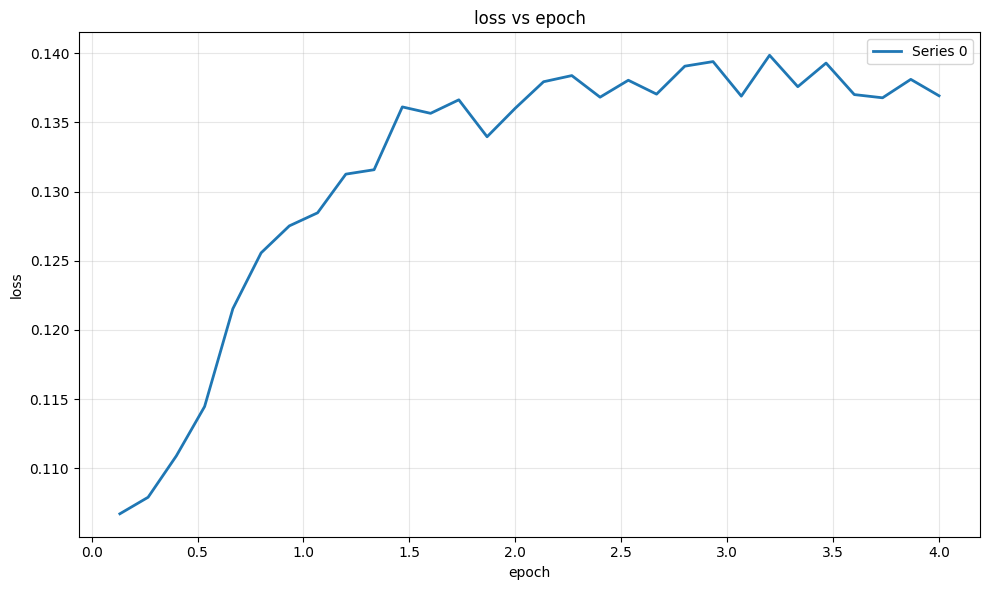

In [41]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

# Momentum

## An Ill-conditioned Problem

We chose a function $f(\vec{x}) = 0.1 x_1^2 + 2 x_2^2$ where $f$ has its minimum at $(0,0)$. The function is very flat in the direction of $x_1$

epoch 20, x1: -0.943467, x2: -0.000073


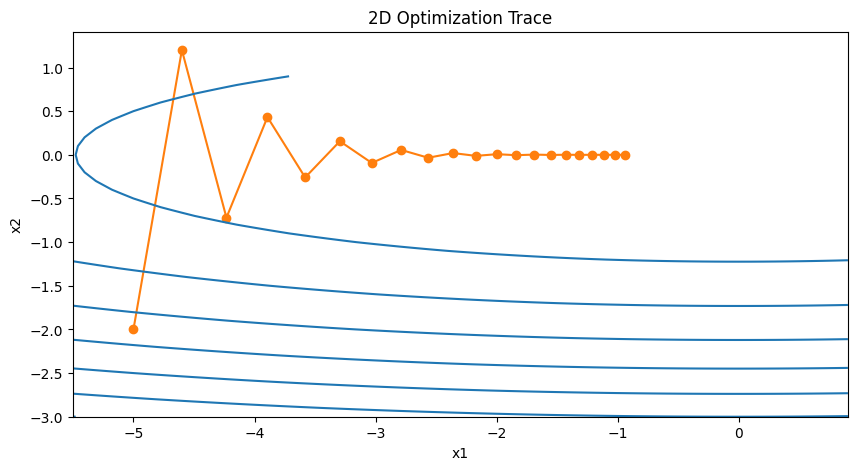

In [42]:

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

By design, the gradient in the $x_2$ direction is much higher and changes more rapidly than in the $x_1$ direction. Making a change in the learning rate to increase it and therefore progress in the direction of $x_1$

epoch 20, x1: -0.387814, x2: -1673.365109


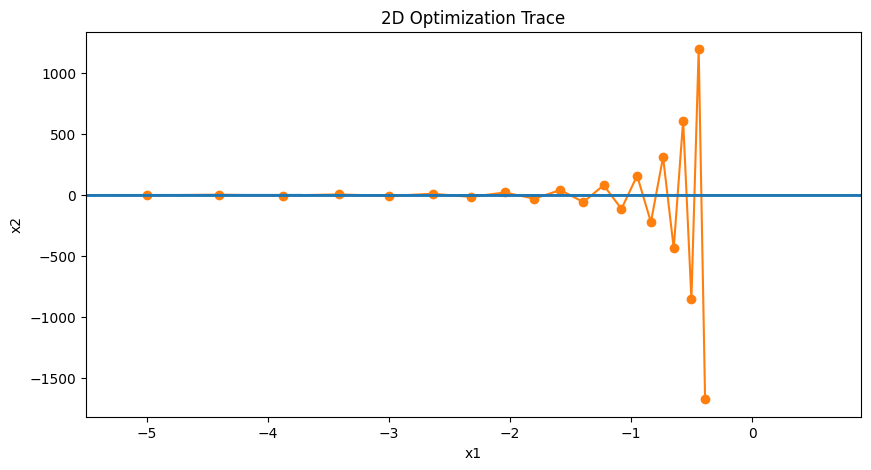

In [43]:
eta = 0.6
show_trace_2d(f_2d, train_2d(gd_2d))

## The Momentum Method

epoch 20, x1: 0.007188, x2: 0.002553


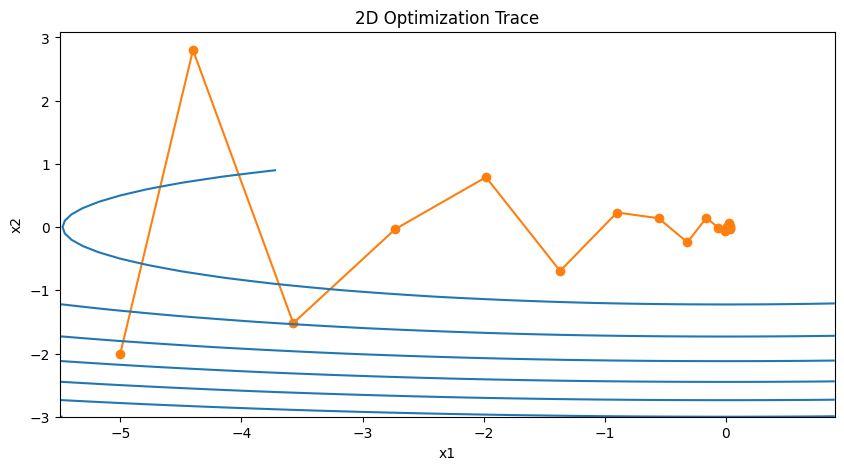

In [44]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

epoch 20, x1: -0.126340, x2: -0.186632


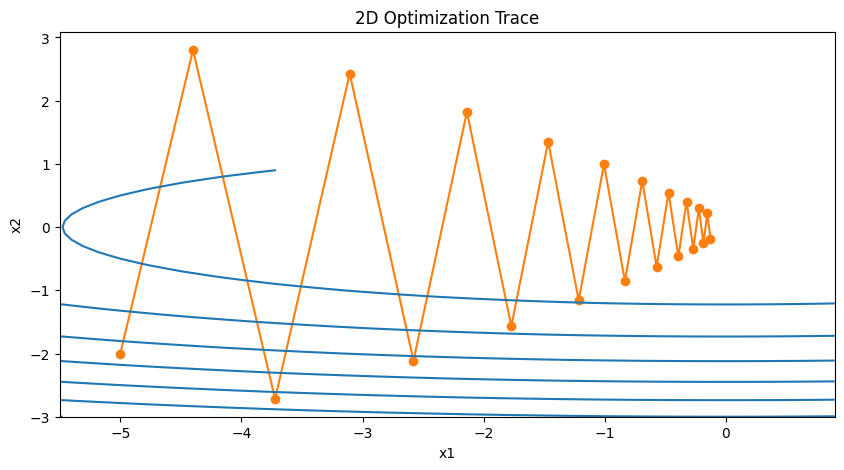

In [45]:
eta, beta = 0.6, 0.25
show_trace_2d(f_2d, train_2d(momentum_2d))

## Effective Sample Weight

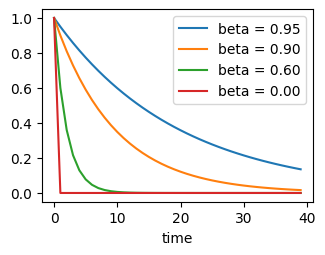

In [46]:
plt.figure(figsize=(3.5, 2.5))
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
plt.xlabel('time')
plt.legend()
plt.show()

## Implementation From Scratch

In [47]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

def train_momentum(lr, momentum, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size=10)  # Get actual feature_dim
    train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                      {'lr': lr, 'momentum': momentum}, data_iter,
                      feature_dim, num_epochs)

Training for 2 epochs...
  Step 5: Loss = 0.2481
  Step 10: Loss = 0.2429
  Step 15: Loss = 0.2428
Final loss: 0.243, 0.066 sec/epoch


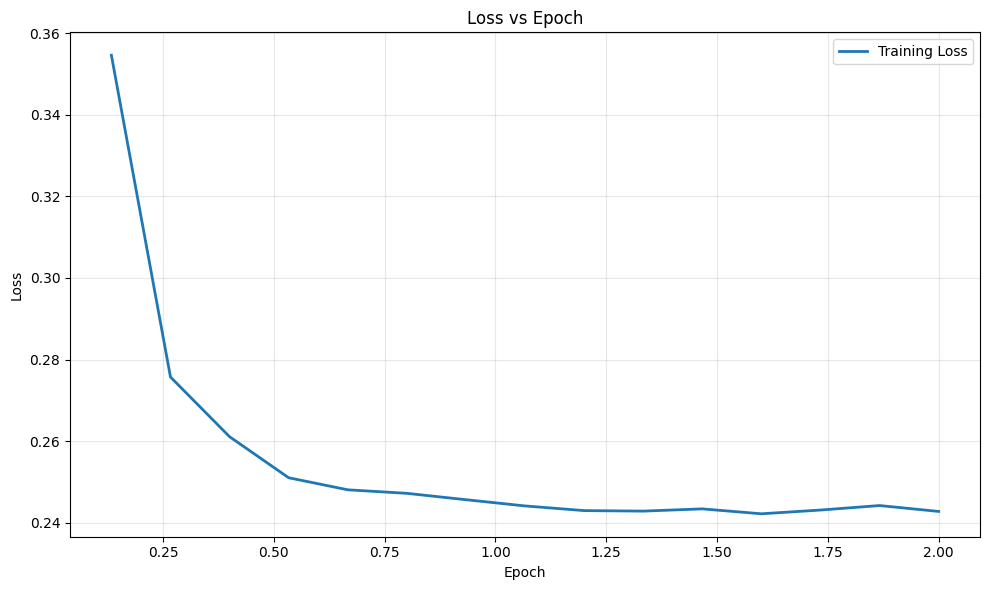

In [48]:
data_iter, feature_dim = get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

Training for 2 epochs...
  Step 5: Loss = 0.2462
  Step 10: Loss = 0.2478
  Step 15: Loss = 0.2528
Final loss: 0.253, 0.076 sec/epoch


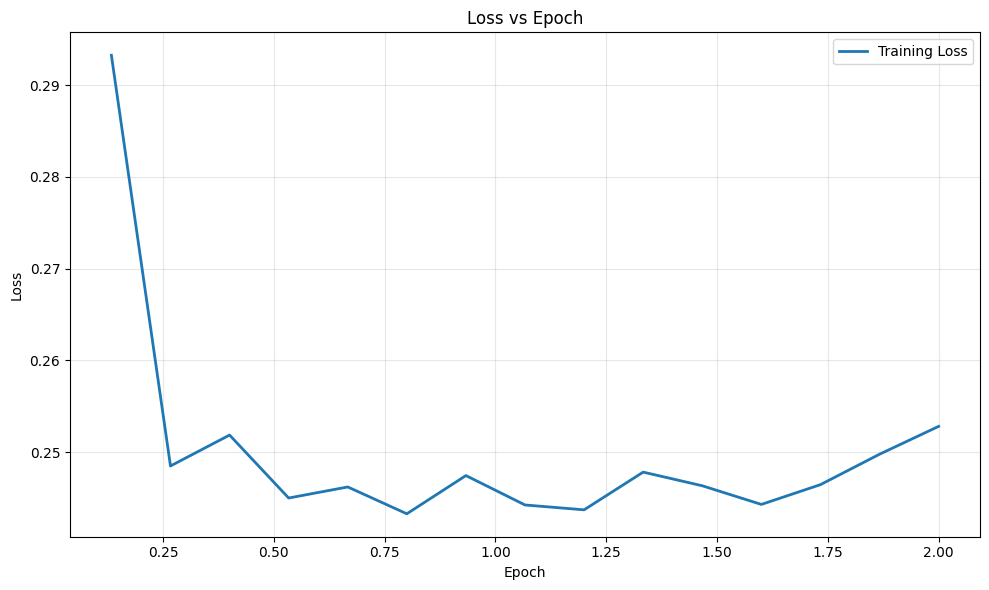

In [49]:
train_momentum(0.01, 0.9)

Training for 2 epochs...
  Step 5: Loss = 0.2466
  Step 10: Loss = 0.2442
  Step 15: Loss = 0.2448
Final loss: 0.245, 0.078 sec/epoch


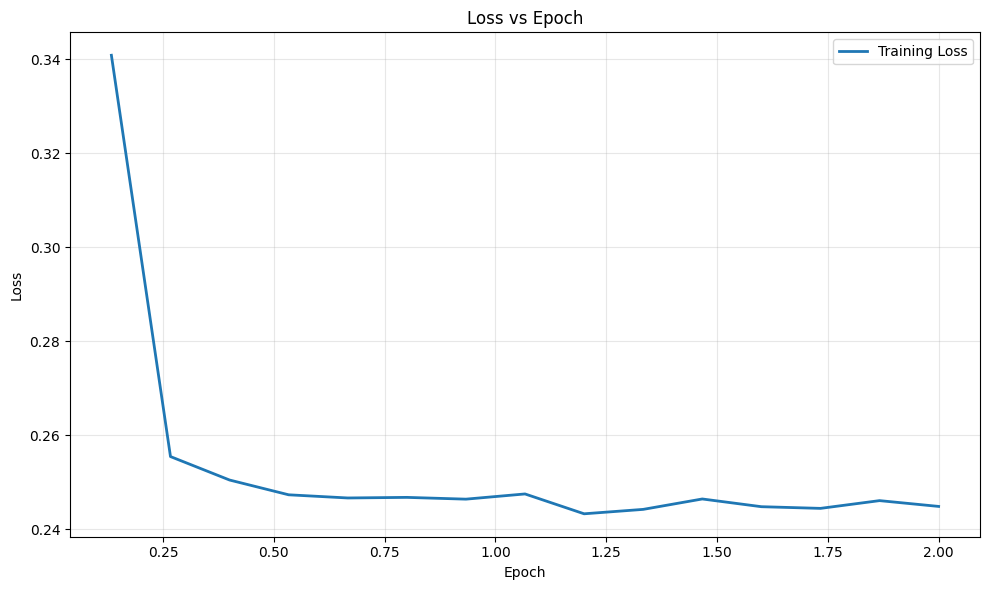

In [50]:
train_momentum(0.005, 0.9)

## Concise Implementation

Training for 4 epochs...
  Step 5: Loss = 0.1203
  Step 10: Loss = 0.1361
  Step 15: Loss = 0.1357
  Step 20: Loss = 0.1394
  Step 25: Loss = 0.1366
  Step 30: Loss = 0.1426
Final loss: 0.143, 0.081 sec/epoch


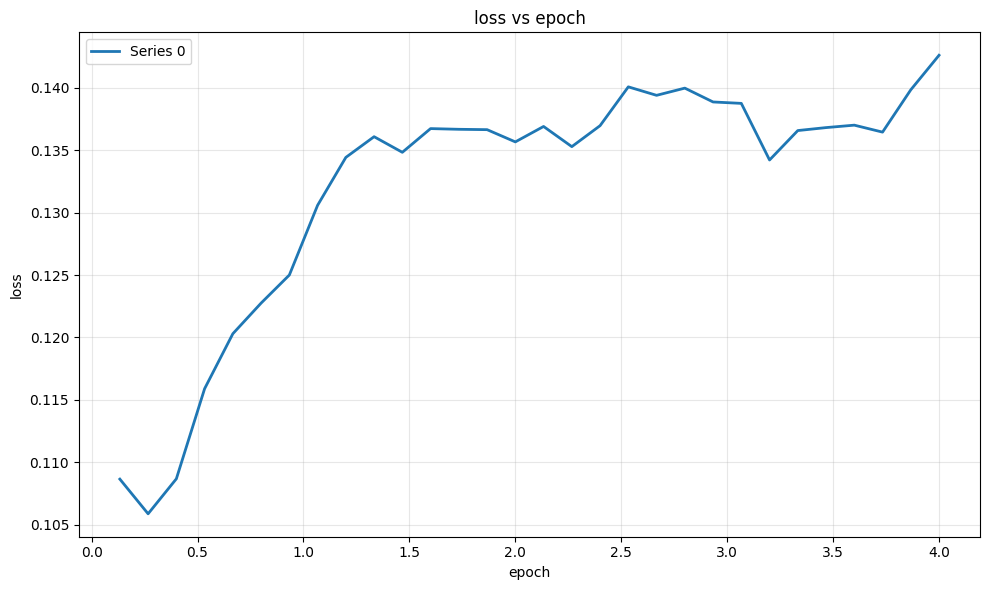

In [51]:
# Use momentum SGD with proper parameters
trainer = torch.optim.SGD
data_iter, _ = get_data_ch11(10)

train_concise_ch11(trainer, {'lr': 0.001, 'momentum': 0.9}, data_iter) 